<a href="https://colab.research.google.com/github/lqiang67/generative-models-on-toys/blob/main/gan_2D_toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

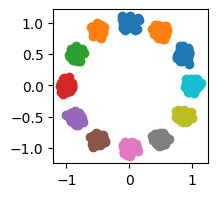

In [7]:
#@title prepare code
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from collections import namedtuple
from IPython.display import clear_output

# MLP architecture
class MLP(nn.Module):
    def __init__(self, layer_sizes, activation=nn.LeakyReLU, linear_layer=nn.Linear):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        self.linear_layer = linear_layer
        for i in range(len(layer_sizes) - 1):
            self.layers.append(self.linear_layer(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:  # No activation after the last layer
                self.layers.append(self.activation())

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x

def plot_contour_2d(discriminator, device, xlim=(-2, 2), ylim=(-2, 2), num_points=100):
    x = np.linspace(xlim[0], xlim[1], num_points)
    y = np.linspace(ylim[0], ylim[1], num_points)
    X, Y = np.meshgrid(x, y)

    # Flatten the grid to pass through the discriminator
    coords = np.vstack([X.ravel(), Y.ravel()]).T
    coords_torch = torch.tensor(coords, dtype=torch.float32).to(device)

    # Disable gradient computation for efficiency
    with torch.no_grad():
        Z = discriminator(coords_torch).cpu().numpy().reshape(X.shape)

    plt.contour(X, Y, Z, levels=20, cmap='viridis')

DataInfo = namedtuple('data_info', ['centers', 'cluster_idx'])
def sample_circular_gmm(batch_size, num_modes=4, radius=1.0, std=0.05):
    angles = torch.linspace(0, 2 * torch.pi, num_modes+1)[:-1] + torch.pi/2
    centers = torch.stack([radius * torch.cos(angles), radius * torch.sin(angles)], dim=1)
    cluster_idx = torch.randint(0, num_modes, (batch_size,))
    selected_centers = centers[cluster_idx]
    batch_data = selected_centers + std * torch.randn(batch_size, 2)

    data_info = DataInfo(centers=centers, cluster_idx=cluster_idx)
    return batch_data, data_info

# Visualize the data
data_points, data_info = sample_circular_gmm(1000, num_modes=12)
plt.figure(figsize=(2, 2))
for i in range(len(data_info.centers)):
    idx = (data_info.cluster_idx == i)
    plt.scatter(data_points[idx, 0], data_points[idx, 1])


Iter: 900, Loss_d: 0.9953259229660034,loss_g: -0.5134823322296143


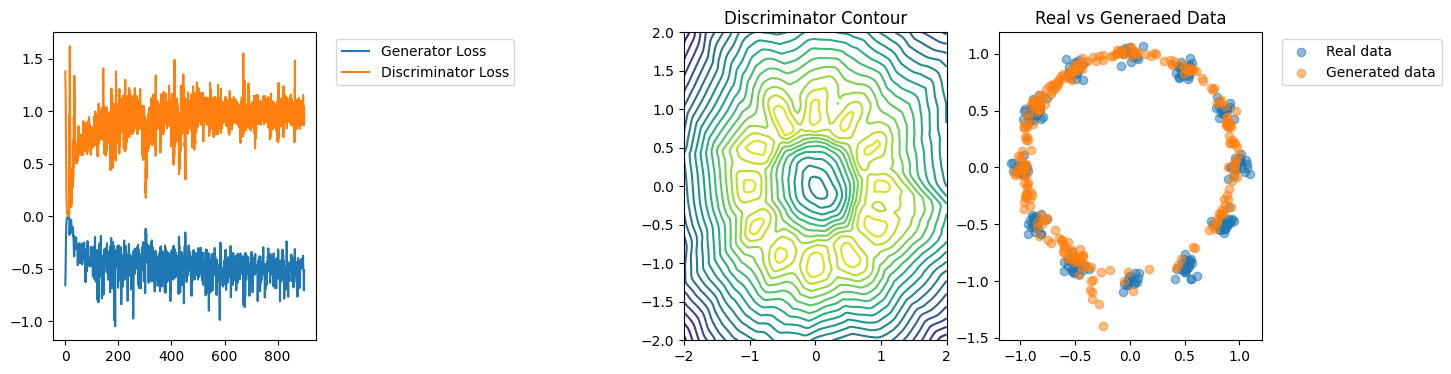

In [8]:
#@title Training GAN

# data
data_points, data_info = sample_circular_gmm(1000, num_modes=12)

# model
noise_dim = 10
data_dim = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = MLP([noise_dim, 128, 128, 128, 128, 128, data_dim]).to(device)
generator.get_noise = lambda batch_size: torch.randn(batch_size, noise_dim).to(device)
discriminator = MLP([data_dim, 128,128, 128, 1]).to(device)


# optimizer
optimizer_g = optim.Adam(generator.parameters(), lr=0.0005, betas = (0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0005, betas= (0.5, 0.999))
criterion = nn.BCEWithLogitsLoss()


batch_size = 256
num_steps = 1000
generator_inner_step = 1
discriminator_inner_step = 10

loss_g_curve = [];
loss_d_curve = []

for iter in range(num_steps):

    ### discriminator update
    for i in range(discriminator_inner_step):
        optimizer_d.zero_grad()

        # data
        real_batch = data_points[torch.randperm(data_points.shape[0])[:batch_size]].to(device)
        fake_batch = generator(generator.get_noise(batch_size)).detach()

        # loss
        real_loss = criterion(discriminator(real_batch), torch.ones(batch_size,1).to(device))
        fake_loss = criterion(discriminator(fake_batch), torch.zeros(batch_size,1).to(device))
        loss_d = real_loss + fake_loss
        loss_d.backward()
        optimizer_d.step()

        loss_d_curve.append(loss_d.item())


    ### generator update
    for i in range(generator_inner_step):
        optimizer_g.zero_grad()

        # data
        fake_batch = generator(generator.get_noise(batch_size))

        # loss
        #loss_g = criterion(discriminator(fake_batch), torch.ones(batch_size,1))
        loss_g = -criterion(discriminator(fake_batch), torch.zeros(batch_size,1).to(device))
        loss_g.backward()
        optimizer_g.step()

        loss_g_curve.append(loss_g.item())

    # plot
    if iter % 100 == 0:
        clear_output(wait=True)
        KK = 10; kk = 1
        plt.figure(figsize=(4*KK,4))

        plt.subplot(1, KK, kk);kk+=2
        plt.plot(torch.linspace(0, iter, len(loss_g_curve)), loss_g_curve, label='Generator Loss')
        plt.plot(torch.linspace(0, iter, len(loss_d_curve)), loss_d_curve, label='Discriminator Loss')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.subplot(1, KK, kk);kk+=1
        plot_contour_2d(discriminator, device)
        plt.title('Discriminator Contour')

        plt.subplot(1, KK, kk);kk+=1
        plt.scatter(real_batch[:, 0].cpu(), real_batch[:, 1].cpu(), alpha=0.5, label='Real data')
        plt.scatter(fake_batch[:, 0].detach().cpu().numpy(), fake_batch[:, 1].detach().cpu().numpy(), alpha=0.5, label='Generated data')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title('Real vs Generaed Data')

        print(f'Iter: {iter}, Loss_d: {loss_d.item()},loss_g: {loss_g.item()}')
        plt.show()
